<a href="https://colab.research.google.com/github/paluigi/AI-IoT-Bootcamp/blob/master/V2_Sentiment_Classification_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original guide: [here](https://towardsdatascience.com/beginners-guide-to-bert-for-multi-classification-task-92f5445c2d7c)

Other guides (not used): [option1](https://towardsdatascience.com/bert-text-classification-in-3-lines-of-code-using-keras-264db7e7a358), [option2](https://medium.com/@aniruddha.choudhury94/part-2-bert-fine-tuning-tutorial-with-pytorch-for-text-classification-on-the-corpus-of-linguistic-18057ce330e1)

Open the link in private browser

Tips and tricks for run_classifier.py:
- edit line 352 to include our own labels
- make the labels as a list of integers

def get_labels(self):

return ['empty','sadness','enthusiasm','neutral','worry','surprise','love', 'fun','hate','happiness','boredom','relief','anger']

return ['0','1','2','3','4','5','6', '7','8','9','10','11','12']


Import libraries

In [1]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
%tensorflow_version 1.x
import tensorflow as tf

%matplotlib inline

TensorFlow 1.x selected.


Import dataset

In [2]:
!git clone https://github.com/paluigi/AI-IoT-Bootcamp.git

Cloning into 'AI-IoT-Bootcamp'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 71 (delta 30), reused 30 (delta 8), pack-reused 0
Unpacking objects: 100% (71/71), done.
Checking out files: 100% (18/18), done.


Load dataset into pandas dataframe

In [3]:
data_df = pd.read_csv("/content/AI-IoT-Bootcamp/datasets/text_emotions/text_emotion.csv")
data_df.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


# Summary of dataset

Dataset size

Number of different *labels*

In [4]:
print(data_df["sentiment"].unique())
print(str(len(data_df["sentiment"].unique())) + " different labels")

['empty' 'sadness' 'enthusiasm' 'neutral' 'worry' 'surprise' 'love' 'fun'
 'hate' 'happiness' 'boredom' 'relief' 'anger']
13 different labels


In [5]:
sent_dict = {}
tot = data_df.shape[0]
for label in data_df["sentiment"].unique():
  t = sum(label == data_df["sentiment"])
  sent_dict[label] = {"count": t, "perc": round((t/tot)*100, 2)}

sent_dict

{'anger': {'count': 110, 'perc': 0.27},
 'boredom': {'count': 179, 'perc': 0.45},
 'empty': {'count': 827, 'perc': 2.07},
 'enthusiasm': {'count': 759, 'perc': 1.9},
 'fun': {'count': 1776, 'perc': 4.44},
 'happiness': {'count': 5209, 'perc': 13.02},
 'hate': {'count': 1323, 'perc': 3.31},
 'love': {'count': 3842, 'perc': 9.61},
 'neutral': {'count': 8638, 'perc': 21.59},
 'relief': {'count': 1526, 'perc': 3.82},
 'sadness': {'count': 5165, 'perc': 12.91},
 'surprise': {'count': 2187, 'perc': 5.47},
 'worry': {'count': 8459, 'perc': 21.15}}

In [6]:
data_df.columns

Index(['tweet_id', 'sentiment', 'author', 'content'], dtype='object')

Emotions from Microsoft Face Analysis:

*   "anger": 0.0,
*   "contempt": 0.0,
*   "disgust": 0.0,
*   "fear": 0.0,
*   "happiness": 1.0,
*   "neutral": 0.0,
*   "sadness": 0.0,
*   "surprise": 0.0




        
        
        
        
        
        
        

Select comparable classes

MS Face <> Text Analysis

anger <> anger, hate

contempt <> anger, hate

disgust <> anger, hate

fear <> worry

happiness <> happiness

neutal <> neutral

sadness <> sadness

surprise <> surprise


In [7]:
print(data_df["sentiment"].unique())


['empty' 'sadness' 'enthusiasm' 'neutral' 'worry' 'surprise' 'love' 'fun'
 'hate' 'happiness' 'boredom' 'relief' 'anger']


In [8]:
sent = np.delete(data_df["sentiment"].unique(), [0,2,6,7,10,11], 0)
print(sent)

['sadness' 'neutral' 'worry' 'surprise' 'hate' 'happiness' 'anger']


Rebalance the dataset

In [9]:
sub_df = pd.DataFrame(columns=data_df.columns)

def sorter(x):
    return sorted(x, key=len, reverse=True)

for label in sent:
  temp = data_df[data_df["sentiment"]== label].copy()
  temp["length"] = temp["content"].str.len()
  temp.sort_values("length", ascending=False, inplace=True)
  temp.drop(columns="length", inplace=True)
  temp = temp[:1500]
  sub_df = sub_df.append(temp, ignore_index=True)

sub_df.describe()

,tweet_id,sentiment,author,content
count,8933,8933,8933,8933
unique,8933,7,8308,8926
top,1961968345,happiness,ChineseLearn,#frenchieb-day #frenchieb-day #frenchieb-day #...
freq,1,1500,15,3


In [10]:
sub_df.head()

,tweet_id,sentiment,author,content
0,1957498023,sadness,Sean2theO,@JasonVonBerg thats the crazy part - was for 1...
1,1957626598,sadness,BRAINknowsBETTR,Dad: &quot;No trips to Lahore for you.&quot; M...
2,1753235875,sadness,MisPenay,"@JayceiiNc im disgusted as well and baron, spe..."
3,1961487855,sadness,GlamGlitterati,"when i cheered,i yelled SHAKE THESE at the end..."
4,1963594527,sadness,jaimilicious,Oh I'm really tired of these migraines! #Endom...


In [11]:
sent_dict_new = {}
tot2 = sub_df.shape[0]
for label in sub_df["sentiment"].unique():
  t = sum(label == sub_df["sentiment"])
  sent_dict_new[label] = {"count": t, "perc": round((t/tot2)*100, 2)}

sent_dict_new

{'anger': {'count': 110, 'perc': 1.23},
 'happiness': {'count': 1500, 'perc': 16.79},
 'hate': {'count': 1323, 'perc': 14.81},
 'neutral': {'count': 1500, 'perc': 16.79},
 'sadness': {'count': 1500, 'perc': 16.79},
 'surprise': {'count': 1500, 'perc': 16.79},
 'worry': {'count': 1500, 'perc': 16.79}}

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 <a list of 13 Text major ticklabel objects>)

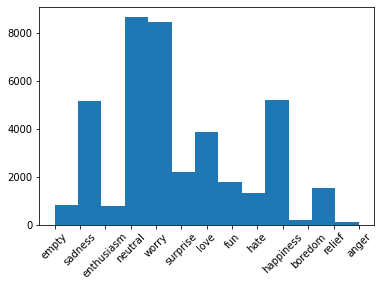

In [12]:
plt.hist(data_df["sentiment"], bins=13)
plt.xticks(rotation=45)

(array([1500., 1500., 1500., 1500., 1323., 1500.,  110.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <a list of 7 Patch objects>)

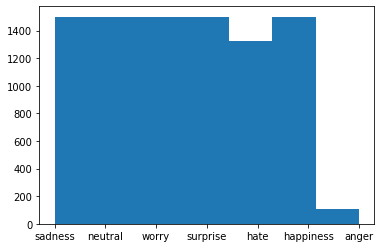

In [13]:
plt.hist(sub_df["sentiment"], bins=7)
#plt.xticks(rotation=45)

Combine "anger" and "hate" , create a summary table for sentiments and transform sentiments in integer strings

In [14]:
legend = pd.DataFrame(sent, columns=["sentiment"])
legend["ind"] = range(legend.shape[0])
legend

,sentiment,ind
0,sadness,0
1,neutral,1
2,worry,2
3,surprise,3
4,hate,4
5,happiness,5
6,anger,6


Combine anger and hate

In [15]:
k = min(legend.loc[legend["sentiment"]== "anger", "ind"].values, legend.loc[legend["sentiment"]== "hate", "ind"].values).item()
legend.loc[legend.sentiment == "anger", "ind"] = k
legend.loc[legend.sentiment == "hate", "ind"] = k
legend

,sentiment,ind
0,sadness,0
1,neutral,1
2,worry,2
3,surprise,3
4,hate,4
5,happiness,5
6,anger,4


Change labels in datasets

In [16]:
for sentiment in legend.sentiment.values:
  sub_df["sentiment"].replace(sentiment, legend.loc[legend["sentiment"]== sentiment, "ind"].values.item(), inplace=True)

sub_df.head()

,tweet_id,sentiment,author,content
0,1957498023,0,Sean2theO,@JasonVonBerg thats the crazy part - was for 1...
1,1957626598,0,BRAINknowsBETTR,Dad: &quot;No trips to Lahore for you.&quot; M...
2,1753235875,0,MisPenay,"@JayceiiNc im disgusted as well and baron, spe..."
3,1961487855,0,GlamGlitterati,"when i cheered,i yelled SHAKE THESE at the end..."
4,1963594527,0,jaimilicious,Oh I'm really tired of these migraines! #Endom...


# Remove special characters, link, handles, etc

Remove links

In [17]:
import re,string

def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ' ')    
    return text

Remove twitter hashtags, keep words


In [18]:
def strip_hashtags(text):
    for word in text:
        text = text.replace("#", "").replace("_", " ")    
    return text

Remove twitter handles

In [19]:
def strip_handles(text):
  entity_prefixes = ['@']
  words = []
  for word in text.split():
    word = word.strip()
    if word:
      if word[0] not in entity_prefixes:
        words.append(word)
  
  return ' '.join(words)

Remove HTML Tags

In [20]:
def strip_tags(text):
    for word in text:
        text = text.replace("&quot;", "").replace("&amp;", "and") 
    return text

In [21]:
sub_df["content"][15]

"@imjustlalayone damn girl I'm so down but ya gotta let me know so I can get my kit together &amp; I got a flyer  Any next weekend? I&quot;M DOWN!"

In [22]:
strip_handles(sub_df["content"][15])

"damn girl I'm so down but ya gotta let me know so I can get my kit together &amp; I got a flyer Any next weekend? I&quot;M DOWN!"

In [23]:
for i, tweet in enumerate(sub_df["content"]):
  tweet = strip_links(tweet)
  tweet = strip_hashtags(tweet)
  tweet = strip_handles(tweet)
  tweet = strip_tags(tweet)
  sub_df["content"][i] = tweet

#sub_df["content"][56]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
sub_df["content"][56]

'Just dusted and vacuumed apartment. I think I need another new vacuum...my entire apartment is smoky. I just bought this one from Kmart'

# Divide dataset between train and test

In [25]:
train_all_df, test_df = train_test_split(sub_df, test_size = 0.2)

Divide train_all dataset in train e dev


In [26]:
train_df, dev_df = train_test_split(train_all_df, test_size = 0.05)

Check basic figures for train, dev, and test datasets

In [27]:
sent_dict_train = {}
tot = train_df.shape[0]
for label in train_df["sentiment"].unique():
  t = sum(label == train_df["sentiment"])
  sent_dict_train[label] = {"count": t, "perc": round((t/tot)*100, 2)}

sent_dict_train

{0: {'count': 1134, 'perc': 16.71},
 1: {'count': 1144, 'perc': 16.85},
 2: {'count': 1154, 'perc': 17.0},
 3: {'count': 1143, 'perc': 16.84},
 4: {'count': 1098, 'perc': 16.18},
 5: {'count': 1115, 'perc': 16.43}}

In [28]:
sent_dict_dev = {}
tot = dev_df.shape[0]
for label in dev_df["sentiment"].unique():
  t = sum(label == dev_df["sentiment"])
  sent_dict_dev[label] = {"count": t, "perc": round((t/tot)*100, 2)}

sent_dict_dev

{0: {'count': 62, 'perc': 17.32},
 1: {'count': 58, 'perc': 16.2},
 2: {'count': 66, 'perc': 18.44},
 3: {'count': 65, 'perc': 18.16},
 4: {'count': 43, 'perc': 12.01},
 5: {'count': 64, 'perc': 17.88}}

In [29]:
sent_dict_test = {}
tot = test_df.shape[0]
for label in test_df["sentiment"].unique():
  t = sum(label == test_df["sentiment"])
  sent_dict_test[label] = {"count": t, "perc": round((t/tot)*100, 2)}

sent_dict_test

{0: {'count': 304, 'perc': 17.01},
 1: {'count': 298, 'perc': 16.68},
 2: {'count': 280, 'perc': 15.67},
 3: {'count': 292, 'perc': 16.34},
 4: {'count': 292, 'perc': 16.34},
 5: {'count': 321, 'perc': 17.96}}

In [30]:
print(str(len(train_df["sentiment"].unique())) + " different labels in Train Dataset")

6 different labels in Train Dataset


In [31]:
print(str(len(dev_df["sentiment"].unique())) + " different labels in Dev Dataset")

6 different labels in Dev Dataset


In [32]:
print(str(len(test_df["sentiment"].unique())) + " different labels in Test Dataset")

6 different labels in Test Dataset


# Download BERT and related files

In [33]:
!git clone https://github.com/google-research/bert.git

Cloning into 'bert'...
remote: Enumerating objects: 340, done.
remote: Total 340 (delta 0), reused 0 (delta 0), pack-reused 340
Receiving objects: 100% (340/340), 317.85 KiB | 7.95 MiB/s, done.
Resolving deltas: 100% (185/185), done.


Chose one BERT model from [this page](https://github.com/google-research/bert).

In [34]:
!wget https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-8_H-512_A-8.zip
!unzip uncased_L-8_H-512_A-8.zip

--2020-08-31 21:35:58--  https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-8_H-512_A-8.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 172.217.203.128, 142.250.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154608092 (147M) [application/zip]
Saving to: ‘uncased_L-8_H-512_A-8.zip’

uncased_L-8_H-512_A 100%[===================>] 147.45M   122MB/s    in 1.2s    

2020-08-31 21:35:59 (122 MB/s) - ‘uncased_L-8_H-512_A-8.zip’ saved [154608092/154608092]

Archive:  uncased_L-8_H-512_A-8.zip
  inflating: bert_model.ckpt.data-00000-of-00001  
  inflating: bert_config.json        
  inflating: vocab.txt               
  inflating: bert_model.ckpt.index   


In [35]:
import os
os.mkdir("bert_output")
os.mkdir("data")

Format Dataframes according to BERT preferences
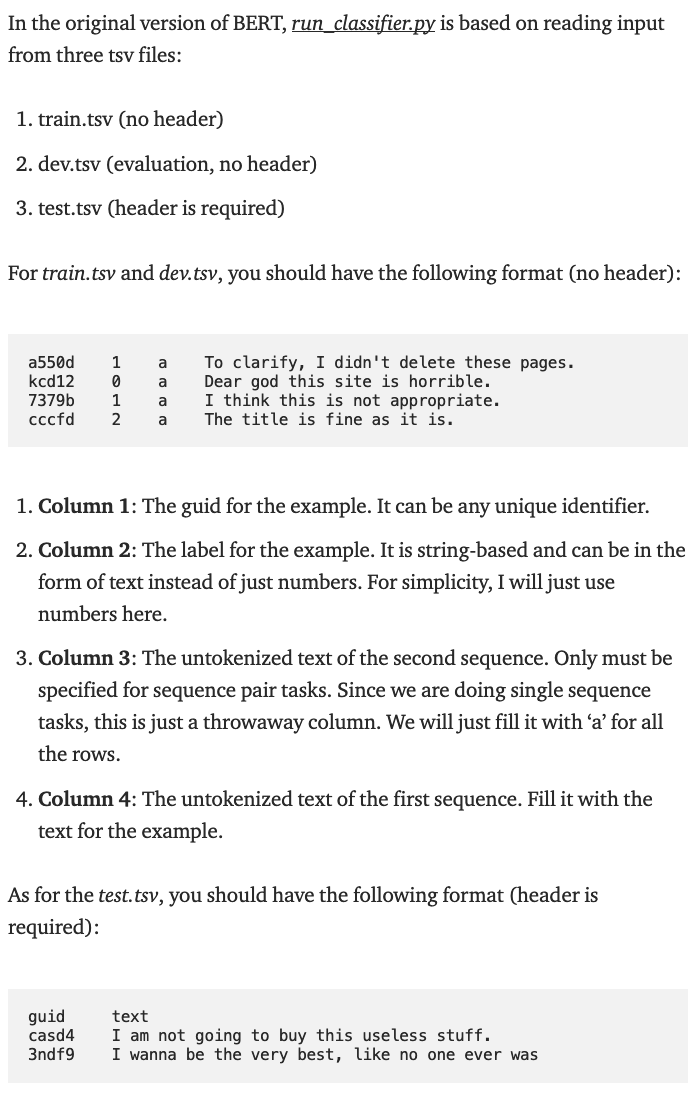

In [36]:
bert_test_df = pd.DataFrame({'guid': test_df['tweet_id'], 'text': test_df['content']})

In [37]:
bert_test_df.head()

,guid,text
6886,1964240048,I kno I kknow ... sigh... been on. but it sux
3129,1963419480,lol awww lol i will i can't do it now lol cauz...
2642,1753836435,Twello Foodie Tweets Do you fancy coming up to...
8251,1751070201,haha...Live long and prosper. The movie was be...
7069,1957435007,Waiting for my driver! Hate to wait!!!!!


In [38]:
train_df.to_csv('data/train.tsv', sep='\t', index=False, header=False)
dev_df.to_csv('data/dev.tsv', sep='\t', index=False, header=False)
bert_test_df.to_csv('data/test.tsv', sep='\t', index=False, header=True)

Load modified run_classfier.py file

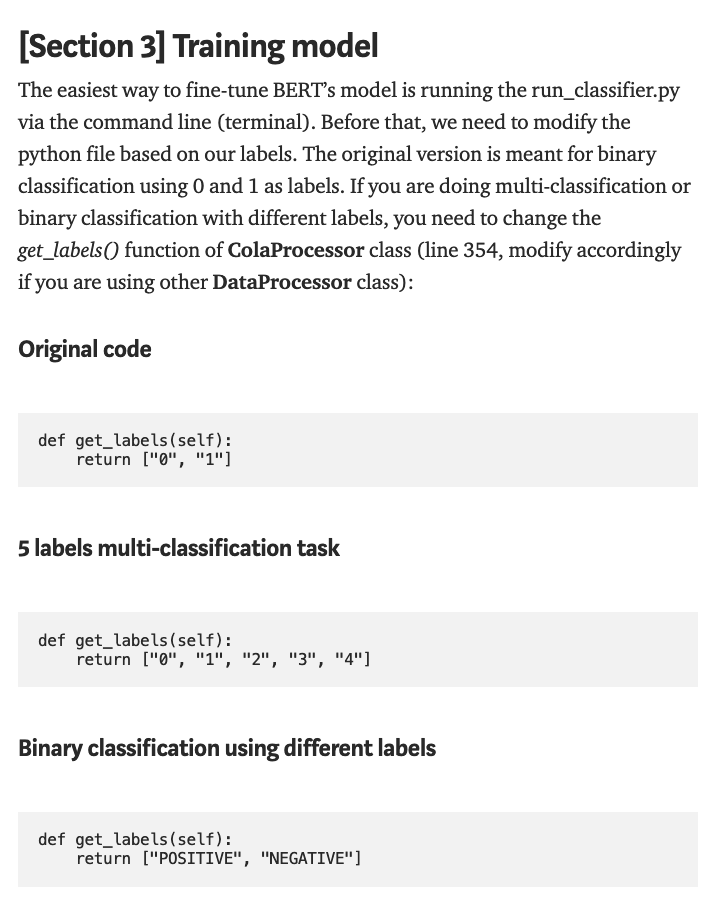

def get_labels(self):
  
    """See base class."""
    return ['0','1','2','3','4','5']


In [ ]:
!python bert/run_classifier.py --task_name=cola --do_train=true --do_eval=true --data_dir=data --vocab_file=vocab.txt --bert_config_file=bert_config.json --init_checkpoint=bert_model.ckpt.index --max_seq_length=64 --train_batch_size=16 --learning_rate=3e-5 --num_train_epochs=4 --output_dir=bert_output --do_lower_case=False --save_checkpoints_steps=999999999




W0831 20:47:31.734344 140483765438336 module_wrapper.py:139] From bert/run_classifier.py:784: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.


W0831 20:47:31.734598 140483765438336 module_wrapper.py:139] From bert/run_classifier.py:784: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.


W0831 20:47:31.735056 140483765438336 module_wrapper.py:139] From /content/bert/modeling.py:93: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0831 20:47:31.735687 140483765438336 module_wrapper.py:139] From bert/run_classifier.py:808: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensor

Run the model on test data to check accuracy

In [ ]:
!python bert/run_classifier.py --task_name=cola --do_predict=true --data_dir=data --vocab_file=vocab.txt --bert_config_file=bert_config.json --init_checkpoint=bert_output/model.ckpt-5700.index --max_seq_length=64 --output_dir=bert_output/




W0828 15:10:16.810214 140620136298368 module_wrapper.py:139] From bert/run_classifier.py:787: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.


W0828 15:10:16.810900 140620136298368 module_wrapper.py:139] From bert/run_classifier.py:787: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.


W0828 15:10:16.811625 140620136298368 module_wrapper.py:139] From /content/bert/modeling.py:93: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0828 15:10:16.812343 140620136298368 module_wrapper.py:139] From bert/run_classifier.py:811: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensor

In [ ]:
test = pd.read_csv("/content/bert_output/test_results.tsv",sep="\t",header=None)
test.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03
mean,2.044500e-02,1.263129e-01,1.836760e-02,2.199940e-01,2.148127e-01,5.418240e-02,9.836133e-02,4.355641e-02,3.323834e-02,1.274562e-01,4.523105e-03,3.614186e-02,2.608109e-03
std,3.643717e-08,9.193968e-08,2.570899e-08,4.292505e-08,7.547931e-08,4.229329e-08,6.408396e-08,5.444555e-08,2.398858e-08,3.330741e-08,1.931380e-08,4.311464e-08,8.201332e-09
min,2.044489e-02,1.263129e-01,1.836752e-02,2.199939e-01,2.148126e-01,5.418228e-02,9.836127e-02,4.355624e-02,3.323827e-02,1.274561e-01,4.523046e-03,3.614172e-02,2.608084e-03
25%,2.044500e-02,1.263129e-01,1.836760e-02,2.199940e-01,2.148127e-01,5.418241e-02,9.836130e-02,4.355642e-02,3.323834e-02,1.274561e-01,4.523104e-03,3.614186e-02,2.608107e-03
50%,2.044501e-02,1.263129e-01,1.836760e-02,2.199940e-01,2.148127e-01,5.418241e-02,9.836131e-02,4.355643e-02,3.323835e-02,1.274562e-01,4.523112e-03,3.614187e-02,2.608111e-03
75%,2.044502e-02,1.263129e-01,1.836761e-02,2.199941e-01,2.148127e-01,5.418242e-02,9.836132e-02,4.355644e-02,3.323835e-02,1.274562e-01,4.523117e-03,3.614188e-02,2.608113e-03
max,2.044502e-02,1.263132e-01,1.836762e-02,2.199941e-01,2.148130e-01,5.418243e-02,9.836152e-02,4.355644e-02,3.323836e-02,1.274563e-01,4.523119e-03,3.614188e-02,2.608115e-03
